# **Etapa 1. Conociendo el negocio**

## Preparación de datos

Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys
import time
warnings.filterwarnings('ignore')

Rutas y archivos esperados

In [2]:
# Rutas
try:
	script_dir = Path(__file__).resolve().parent
except NameError:
	import os
	script_dir = Path(os.getcwd()).resolve()
project_dir = script_dir.parent
data_dir = project_dir / "data_raw"
output_dir = project_dir / "data_processed"
output_dir.mkdir(parents=True, exist_ok=True)

# Archivos esperados
file_2324 = data_dir / "DATOS HISTÓRICOS 2023_2024_TODAS ESTACIONES_ITESM.xlsx"
file_2024 = data_dir / "DATOS HISTÓRICOS 2024_TODAS ESTACIONES.xlsx"
file_2025 = data_dir / "DATOS HISTÓRICOS 2025_TODAS ESTACIONES.xlsx"

Mapeo de estaciones

In [3]:
estaciones_mapping = {
    "SUR": "SUR", "SURESTE": "SUR", "SE": "SUR", "SE2": "SUR", "SE3": "SUR",
    "SO": "SUROESTE2", "SO2": "SUROESTE2", "SUROESTE2": "SUROESTE2", "SUROESTE": "SUROESTE2",
    "NTE": "NORTE2", "NTE2": "NORTE2", "NORTE2": "NORTE2", "NORTE": "NORTE2",
    "CE": "CENTRO", "CENTRO": "CENTRO",
    "NE": "NORESTE3", "NE2": "NORESTE3", "NE3": "NORESTE3", "NORESTE3": "NORESTE3", "NORESTE": "NORESTE3",
    "NO": "NOROESTE3", "NO2": "NOROESTE3", "NO3": "NOROESTE3", "NOROESTE3": "NOROESTE3", "NOROESTE": "NOROESTE3"
}
contaminantes = ["NO2", "CO", "PM2.5", "PM10", "O3"]

Función para estandarizar la estación

In [4]:
def estandarizar_estacion(nombre):
    nombre_clean = str(nombre).upper().strip().replace(" ", "")
    if nombre_clean in estaciones_mapping:
        return estaciones_mapping[nombre_clean]
    for clave, valor in estaciones_mapping.items():
        if clave in nombre_clean or nombre_clean in clave:
            return valor
    return None

Funciones de carga

In [5]:
def safe_read_excel(path, **kwargs):
    """Intentar leer Excel y capturar error por dependencia faltante (openpyxl)."""
    try:
        return pd.read_excel(path, **kwargs)
    except ImportError as ie:
        print("ERROR: Falta dependencia para leer Excel (openpyxl). Instálela en su entorno:")
        print("  python -m pip install openpyxl")
        raise
    except Exception as e:
        # Re-lanzamos para que el llamador decida
        raise

In [6]:
def load_2324(file_path):
    """Carga el archivo 2023-2024 que tiene encabezados en 3 filas y lo convierte a formato long."""
    if not file_path.exists():
        print(f"Archivo 2324 no encontrado: {file_path}")
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])

    try:
        df_raw = safe_read_excel(file_path, header=[0,1,2])
    except Exception as e:
        print(f"Error leyendo 2324: {type(e).__name__}: {e}")
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])

    # localizar columna de fecha
    date_col_idx = None
    for idx, col in enumerate(df_raw.columns):
        col_str = " ".join([str(c).lower() for c in col if pd.notna(c)])
        if 'fecha' in col_str or 'date' in col_str or 'time' in col_str:
            date_col_idx = idx
            break
    if date_col_idx is None:
        print("No se encontró columna de fecha en 2324; devolviendo vacío")
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])

    date_values = df_raw.iloc[:, date_col_idx].copy()

    new_cols = []
    for idx, col in enumerate(df_raw.columns):
        if idx == date_col_idx:
            new_cols.append('date')
        else:
            est = col[0] if isinstance(col, tuple) else col
            param = col[1] if isinstance(col, tuple) and len(col) > 1 else ''
            est_clean = estandarizar_estacion(str(est))
            if est_clean is not None:
                new_cols.append(f"{est_clean}_{str(param).upper()}")
            else:
                new_cols.append(None)

    df_raw.columns = new_cols
    cols_to_drop = [c for c in df_raw.columns if c is None]
    if cols_to_drop:
        df_raw = df_raw.drop(columns=cols_to_drop)

    df_raw['date'] = date_values
    df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')
    df_raw = df_raw.dropna(subset=['date'])

    df_long = df_raw.melt(id_vars='date', var_name='est_param', value_name='valor')
    if len(df_long)==0:
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])

    df_long[['estacion','parametro']] = df_long['est_param'].str.split('_', n=1, expand=True)
    df_long = df_long.drop(columns=['est_param'])
    df_long['parametro'] = df_long['parametro'].str.upper()
    return df_long[['date','estacion','parametro','valor']]



In [7]:
def load_year_sheets(file_path):
    """Carga un archivo donde cada hoja corresponde a una estación; intenta detectar columna fecha y hace melt."""
    if not file_path.exists():
        print(f"Archivo no encontrado: {file_path}")
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])

    try:
        xls = pd.ExcelFile(file_path)
    except ImportError:
        print("ERROR: Falta dependencia para leer Excel (openpyxl). Instálela en su entorno:")
        print("  python -m pip install openpyxl")
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])
    except Exception as e:
        print(f"Error abriendo {file_path.name}: {type(e).__name__}: {e}")
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])

    dfs = []
    for sheet in xls.sheet_names:
        estacion_est = estandarizar_estacion(sheet)
        if estacion_est is None:
            continue
        try:
            df_temp = safe_read_excel(file_path, sheet_name=sheet)
        except Exception as e:
            print(f"  Error leyendo hoja {sheet}: {type(e).__name__}")
            continue

        # normalizar columnas
        df_temp.columns = df_temp.columns.astype(str)
        # detectar columna fecha
        date_col = None
        for c in df_temp.columns:
            if 'FECHA' in c.upper() or 'DATE' in c.upper() or 'HORA' in c.upper():
                date_col = c
                break
        if date_col is None:
            print(f"  Advertencia: no se halló columna fecha en hoja {sheet}; se omite")
            continue

        df_temp['date'] = pd.to_datetime(df_temp[date_col], errors='coerce')
        df_temp = df_temp.dropna(subset=['date'])
        df_temp['estacion'] = estacion_est

        df_long = df_temp.melt(id_vars=['date','estacion'], var_name='parametro', value_name='valor')
        df_long['parametro'] = df_long['parametro'].astype(str).str.extract(r'([A-Z0-9.]+)', expand=False).str.strip()
        dfs.append(df_long[['date','estacion','parametro','valor']])

    if len(dfs) > 0:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame(columns=['date','estacion','parametro','valor'])


## Estadísticos y reportes

In [8]:
def compute_and_save_stats(df, label, out_dir):
    """Imprime y guarda resumen de estadísticas descriptivas, faltantes y por grupo."""
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"stats_{label}.txt"

    with open(out_file, 'w', encoding='utf-8') as f:
        def w(line=''):
            print(line)
            f.write(str(line) + '\n')

        w('='*80)
        w(f'STATS: {label.upper()}')
        w('='*80)

        w(f"Total registros: {len(df):,}")
        if len(df)>0 and 'date' in df.columns:
            try:
                w(f"Rango fechas: {df['date'].min()}  a  {df['date'].max()}")
            except Exception:
                pass

        w('\nResumen por parámetro:')
        if len(df)>0:
            try:
                stats_param = df.groupby('parametro')['valor'].describe()
                w(stats_param.to_string())
            except Exception as e:
                w(f"  No fue posible calcular describe por parametro: {e}")

        w('\nFaltantes por parámetro:')
        if len(df)>0:
            miss_param = df.groupby('parametro')['valor'].agg(lambda x: (x.isna().sum(), 100*x.isna().sum()/len(x)))
            for param, tup in miss_param.items():
                w(f"  - {param}: {tup[0]} faltantes ({tup[1]:.1f}%)")

        w('\nFaltantes por estación:')
        if len(df)>0:
            miss_est = df.groupby('estacion')['valor'].agg(lambda x: (x.isna().sum(), 100*x.isna().sum()/len(x)))
            for est, tup in miss_est.items():
                w(f"  - {est}: {tup[0]} faltantes ({tup[1]:.1f}%)")

        w('\nConteos por (estacion, parametro):')
        if len(df)>0:
            cnt = df.groupby(['estacion','parametro']).size().sort_values(ascending=False)
            for idx, val in cnt.items():
                w(f"  - {idx}: {val}")

        w('\nPorcentaje valores NaN totales:')
        if len(df)>0:
            total_nan = df['valor'].isna().sum()
            w(f"  {total_nan} ({100*total_nan/len(df):.1f}%)")

    print(f"✓ Estadísticos guardados en: {out_file}")
    return out_file


Funciones para generar gráficos

In [9]:
def ensure_datetime(df):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [10]:
def generate_eda_plots(df, plots_dir):
    plots_dir = Path(plots_dir)
    plots_dir.mkdir(parents=True, exist_ok=True)
    if len(df) == 0:
        print(f"  (EDA) DataFrame vacío, omitiendo gráficos en {plots_dir}")
        return

    ensure_datetime(df)
    # Normalizar columnas
    if 'parametro' in df.columns:
        df['parametro'] = df['parametro'].astype(str).str.upper()
    df_clean = df.dropna(subset=['valor'])

    try:
        # Valores faltantes por parámetro
        fig, ax = plt.subplots(figsize=(12, 6))
        missing_by_param = df.groupby('parametro')['valor'].apply(lambda x: x.isna().sum())
        colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, max(1, len(missing_by_param))))
        bars = ax.bar(missing_by_param.index, missing_by_param.values, color=colors, edgecolor='black', linewidth=1.5)
        ax.set_ylabel('Registros faltantes', fontsize=12, fontweight='bold')
        ax.set_xlabel('Parámetro', fontsize=12, fontweight='bold')
        ax.set_title('Valores Faltantes por Parámetro', fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.savefig(plots_dir / "01_valores_faltantes.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Boxplot por parámetro
        fig, ax = plt.subplots(figsize=(14, 7))
        sns.boxplot(data=df_clean, x='parametro', y='valor', ax=ax, palette='Set2')
        ax.set_xlabel('Parámetro', fontsize=12, fontweight='bold')
        ax.set_ylabel('Concentración', fontsize=12, fontweight='bold')
        ax.set_title('Distribución de Concentraciones por Parámetro', fontsize=14, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(plots_dir / "02_distribucion_boxplot.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Histogramas por parámetro
        parametros_list = sorted(df['parametro'].dropna().unique())
        n_params = len(parametros_list)
        if n_params > 0:
            n_cols = 3
            n_rows = (n_params + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
            axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
            for idx, param in enumerate(parametros_list):
                ax = axes[idx]
                data = df[df['parametro'] == param]['valor'].dropna()
                if len(data) > 0:
                    ax.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
                    ax.set_title(f'{param}', fontsize=11, fontweight='bold')
                    ax.set_xlabel('Concentración', fontsize=10)
                    ax.set_ylabel('Frecuencia', fontsize=10)
                    ax.grid(axis='y', alpha=0.3)
                    stats_text = f"Media: {data.mean():.2f}\nDesv.Est: {data.std():.2f}\nN: {len(data)}"
                    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            for idx in range(len(parametros_list), len(axes)):
                fig.delaxes(axes[idx])
            plt.suptitle('Histogramas de Concentraciones por Parámetro', fontsize=14, fontweight='bold', y=0.995)
            plt.tight_layout()
            plt.savefig(plots_dir / "03_histogramas.png", dpi=300, bbox_inches='tight')
            plt.close()

        # Series de tiempo para parámetros principales
        main_params = ['O3', 'PM10', 'NO2']
        n_params = len(main_params)
        if n_params > 0:
            fig, axes = plt.subplots(n_params, 1, figsize=(16, 5*n_params))
            if n_params == 1:
                axes = [axes]
            colors_estaciones = {
                'SUR': '#1f77b4','SUROESTE2': '#ff7f0e','NORTE2': '#2ca02c','CENTRO': '#d62728','NORESTE3': '#9467bd','NOROESTE3': '#8c564b'
            }
            for idx, param in enumerate(main_params):
                ax = axes[idx]
                if param not in df['parametro'].unique():
                    ax.text(0.5, 0.5, f'{param} no disponible', ha='center', va='center', transform=ax.transAxes)
                    continue
                for estacion in sorted(df['estacion'].dropna().unique()):
                    data = df[(df['estacion'] == estacion) & (df['parametro'] == param)].copy()
                    if data.empty:
                        continue
                    data = data.sort_values('date').groupby('date')['valor'].mean()
                    ax.plot(data.index, data.values, label=estacion, linewidth=2, color=colors_estaciones.get(estacion, None), alpha=0.8)
                ax.set_title(f'Series de Tiempo - {param}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Fecha', fontsize=11)
                ax.set_ylabel('Concentración', fontsize=11)
                ax.legend(loc='best', fontsize=9, ncol=2)
                ax.grid(alpha=0.3)
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            plt.suptitle('Series de Tiempo de Contaminantes Principales - Todas las Estaciones', fontsize=14, fontweight='bold', y=0.995)
            plt.tight_layout()
            plt.savefig(plots_dir / "04_series_tiempo.png", dpi=300, bbox_inches='tight')
            plt.close()

        # Comparación entre estaciones: promedio y conteos
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        pivot_data = df.dropna(subset=['valor']).groupby(['estacion','parametro'])['valor'].mean().unstack()
        sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Concentración promedio'})
        axes[0].set_title('Concentración Promedio por Estación y Parámetro', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Estación', fontsize=11)
        axes[0].set_xlabel('Parámetro', fontsize=11)
        counts = df.dropna(subset=['valor']).groupby(['estacion','parametro']).size().unstack()
        sns.heatmap(counts, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Cantidad de registros'})
        axes[1].set_title('Cantidad de Registros por Estación y Parámetro', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Estación', fontsize=11)
        axes[1].set_xlabel('Parámetro', fontsize=11)
        plt.tight_layout()
        plt.savefig(plots_dir / "05_comparacion_estaciones.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Correlación entre parámetros
        df_pivot = df.dropna(subset=['valor']).pivot_table(index='date', columns='parametro', values='valor', aggfunc='mean')
        if df_pivot.shape[1] > 0:
            corr_matrix = df_pivot.corr()
            fig, ax = plt.subplots(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlación'}, ax=ax, vmin=-1, vmax=1)
            ax.set_title('Matriz de Correlación entre Parámetros', fontsize=13, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig(plots_dir / "06_correlacion.png", dpi=300, bbox_inches='tight')
            plt.close()

        # Tendencia temporal
        n_params = len(main_params)
        fig, axes = plt.subplots(n_params, 1, figsize=(16, 5*n_params))
        if n_params == 1:
            axes = [axes]
        for idx, param in enumerate(main_params):
            ax = axes[idx]
            if param not in df['parametro'].unique():
                ax.text(0.5, 0.5, f'{param} no disponible', ha='center', va='center', transform=ax.transAxes)
                continue
            for estacion in sorted(df['estacion'].dropna().unique()):
                data = df[(df['estacion'] == estacion) & (df['parametro'] == param)].copy()
                if data.empty:
                    continue
                data = data.sort_values('date').groupby('date')['valor'].mean()
                ma_30 = data.rolling(window=30, center=True).mean()
                ax.plot(ma_30.index, ma_30.values, label=estacion, linewidth=2.5, alpha=0.8)
            ax.set_title(f'Tendencia Temporal - {param} (Media Móvil 30d)', fontsize=12, fontweight='bold')
            ax.set_xlabel('Fecha', fontsize=11)
            ax.set_ylabel('Concentración', fontsize=11)
            ax.legend(loc='best', fontsize=9, ncol=2)
            ax.grid(alpha=0.3)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        plt.suptitle('Tendencia Temporal por Estación - Todas las Estaciones', fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(plots_dir / "07_tendencia_temporal.png", dpi=300, bbox_inches='tight')
        plt.close()

        print(f" Gráficos guardados en: {plots_dir}")

    except Exception as e:
        print(f" Error generando gráficos en {plots_dir}: {type(e).__name__} {e}")


In [11]:
def generate_comprehension_plots(df_before, df_after, out_base_dir):
    out_base_dir = Path(out_base_dir)
    part2_dir = out_base_dir / 'parte2_comprension'
    part2_dir.mkdir(parents=True, exist_ok=True)
    plots_dir = part2_dir

    # Heatmap de faltantes (antes)
    try:
        if len(df_before) > 0:
            ensure_datetime(df_before)
            missing_matrix = df_before.groupby(['estacion','parametro'])['valor'].apply(lambda x: 100 * x.isna().sum() / len(x)).unstack()
            fig, ax = plt.subplots(figsize=(12,6))
            sns.heatmap(missing_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r', cbar_kws={'label':'% Faltantes'}, ax=ax, vmin=0, vmax=100)
            ax.set_title('Porcentaje de Datos Faltantes por Estación y Parámetro\n(ANTES DE LIMPIEZA)', fontsize=13, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig(plots_dir / '01_ANTES_datos_faltantes_heatmap.png', dpi=300, bbox_inches='tight')
            plt.close()

        # Barras de faltantes por parámetro (antes)
        if len(df_before) > 0:
            fig, ax = plt.subplots(figsize=(12,6))
            missing_by_param = df_before.groupby('parametro')['valor'].apply(lambda x: x.isna().sum())
            colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, max(1, len(missing_by_param))))
            bars = ax.bar(missing_by_param.index, missing_by_param.values, color=colors, edgecolor='black', linewidth=1.5)
            ax.set_ylabel('Registros faltantes', fontsize=12, fontweight='bold')
            ax.set_xlabel('Parámetro', fontsize=12, fontweight='bold')
            ax.set_title('Valores Faltantes por Parámetro\n(ANTES DE LIMPIEZA)', fontsize=13, fontweight='bold', pad=20)
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            plt.tight_layout()
            plt.savefig(plots_dir / '02_ANTES_valores_faltantes_por_param.png', dpi=300, bbox_inches='tight')
            plt.close()

        # Cobertura temporal por mes (antes)
        if len(df_before) > 0:
            dfb = df_before.copy()
            ensure_datetime(dfb)
            dfb['mes'] = dfb['date'].dt.to_period('M')
            coverage = dfb.groupby('mes')['valor'].apply(lambda x: 100 * x.notna().sum() / len(x))
            fig, ax = plt.subplots(figsize=(14,6))
            ax.plot(coverage.index.astype(str), coverage.values, marker='o', linewidth=2, markersize=6, color='steelblue')
            ax.fill_between(range(len(coverage)), coverage.values, alpha=0.3, color='steelblue')
            ax.set_ylabel('% Datos Válidos', fontsize=12, fontweight='bold')
            ax.set_xlabel('Mes', fontsize=12, fontweight='bold')
            ax.set_title('Cobertura de Datos Válidos por Mes\n(ANTES DE LIMPIEZA)', fontsize=13, fontweight='bold', pad=20)
            ax.set_ylim([0,105])
            ax.grid(alpha=0.3)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(plots_dir / '03_ANTES_cobertura_temporal.png', dpi=300, bbox_inches='tight')
            plt.close()

        # Heatmap (después)
        if len(df_after) > 0:
            missing_matrix_after = df_after.groupby(['estacion','parametro'])['valor'].apply(lambda x: 100 * x.isna().sum() / len(x) if len(x)>0 else 0).unstack()
            fig, ax = plt.subplots(figsize=(12,6))
            sns.heatmap(missing_matrix_after, annot=True, fmt='.1f', cmap='Greens', cbar_kws={'label':'% Faltantes'}, ax=ax, vmin=0, vmax=100)
            ax.set_title('Porcentaje de Datos Faltantes por Estación y Parámetro\n(DESPUÉS DE LIMPIEZA)', fontsize=13, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig(plots_dir / '04_DESPUES_datos_faltantes_heatmap.png', dpi=300, bbox_inches='tight')
            plt.close()

        # Comparación ANTES vs DESPUÉS
        if len(df_before)>0:
            dfb = df_before
            dfa = df_after
            antes_values = [dfb['valor'].notna().sum(), dfb['valor'].isna().sum()]
            despues_values = [len(dfa), 0]
            fig, axes = plt.subplots(1,2, figsize=(14,6))
            x = np.arange(2)
            width = 0.35
            axes[0].bar(x - width/2, antes_values, width, color=['green','red'], alpha=0.7)
            axes[0].set_title('ANTES DE LIMPIEZA', fontsize=12, fontweight='bold')
            axes[0].set_xticks([])
            axes[0].text(-0.2, antes_values[0]/2, f"{antes_values[0]:,}\n({100*antes_values[0]/sum(antes_values):.1f}%)", ha='center', va='center', fontweight='bold', fontsize=10, color='white')
            axes[0].text(0.2, antes_values[1]/2, f"{antes_values[1]:,}\n({100*antes_values[1]/sum(antes_values):.1f}%)", ha='center', va='center', fontweight='bold', fontsize=10, color='white')
            axes[1].bar(x - width/2, despues_values, width, color=['green','red'], alpha=0.7)
            axes[1].set_title('DESPUÉS DE LIMPIEZA', fontsize=12, fontweight='bold')
            axes[1].set_xticks([])
            axes[1].text(-0.2, despues_values[0]/2, f"{despues_values[0]:,}\n(100%)", ha='center', va='center', fontweight='bold', fontsize=10, color='white')
            plt.suptitle('Comparación ANTES vs DESPUÉS de Limpieza', fontsize=13, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.savefig(plots_dir / '05_COMPARACION_antes_despues.png', dpi=300, bbox_inches='tight')
            plt.close()

        # Distribuciones después
        if len(df_after)>0:
            parametros_list = sorted(df_after['parametro'].dropna().unique())
            n_params = len(parametros_list)
            if n_params>0:
                n_cols=3
                n_rows=(n_params + n_cols -1)//n_cols
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,4*n_rows))
                axes = axes.flatten()
                for idx, param in enumerate(parametros_list):
                    ax = axes[idx]
                    data = df_after[df_after['parametro']==param]['valor']
                    ax.hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
                    ax.set_title(f'{param}', fontsize=11, fontweight='bold')
                    ax.set_xlabel('Concentración', fontsize=10)
                    ax.set_ylabel('Frecuencia', fontsize=10)
                    ax.grid(axis='y', alpha=0.3)
                    stats_text = f"Media: {data.mean():.2f}\nDesv.Est: {data.std():.2f}\nN: {len(data):,}"
                    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                for idx in range(len(parametros_list), len(axes)):
                    fig.delaxes(axes[idx])
                plt.suptitle('Distribuciones de Parámetros (DESPUÉS DE LIMPIEZA)', fontsize=14, fontweight='bold', y=0.995)
                plt.tight_layout()
                plt.savefig(plots_dir / '06_distribucion_parametros.png', dpi=300, bbox_inches='tight')
                plt.close()

            fig, ax = plt.subplots(figsize=(12,6))
            df_after.boxplot(column='valor', by='parametro', ax=ax)
            ax.set_title('Boxplots por Parámetro - Detección de Outliers\n(DESPUÉS DE LIMPIEZA)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Concentración', fontsize=11, fontweight='bold')
            ax.set_xlabel('Parámetro', fontsize=11, fontweight='bold')
            plt.suptitle('')
            plt.tight_layout()
            plt.savefig(plots_dir / '07_boxplots_outliers.png', dpi=300, bbox_inches='tight')
            plt.close()

        print(f"Gráficos de comprensión guardados en: {part2_dir}")

    except Exception as e:
        print(f" Error generando gráficos de comprensión: {type(e).__name__} {e}")


## Pipeline principal

In [12]:
def main():
    print('\nINICIO SCRIPT COMBINADO')
    print(f'  Script dir: {script_dir}')
    print(f'  Data dir: {data_dir} (existe: {data_dir.exists()})')

    # Cargar datasets
    print('\nCargando 2324...')
    df_2324 = load_2324(file_2324)
    print(f'  2324 registros cargados: {len(df_2324)}')

    print('\nCargando 2024 (por hojas)...')
    df_2024 = load_year_sheets(file_2024)
    print(f'  2024 registros cargados: {len(df_2024)}')

    print('\nCargando 2025 (por hojas)...')
    df_2025 = load_year_sheets(file_2025)
    print(f'  2025 registros cargados: {len(df_2025)}')

    # Concatenar
    dfs = [df for df in [df_2324, df_2024, df_2025] if len(df)>0]
    if len(dfs)==0:
        print('No hay datos cargados. Termino.')
        return

    df_full = pd.concat(dfs, ignore_index=True)
    print(f'\nTotal concatenado: {len(df_full)} registros')

    # Normalizar columnas clave
    if 'parametro' in df_full.columns:
        df_full['parametro'] = df_full['parametro'].astype(str).str.upper()
    if 'estacion' in df_full.columns:
        df_full['estacion'] = df_full['estacion'].astype(str)

    # Estadísticos ANTES (raw concatenado)
    compute_and_save_stats(df_full, 'before', output_dir)
    # Generar gráficos EDA para datos "ANTES"
    plots_dir_before = output_dir / 'graficos_before'
    generate_eda_plots(df_full, plots_dir_before)


    print('\nAplicando filtro de contaminantes y limpieza básica...')
    df_filtered = df_full.copy()
    df_filtered = df_filtered[df_filtered['parametro'].isin([c.upper() for c in contaminantes])]

    # Quitar valores imposibles
    df_filtered.loc[df_filtered['valor'] < 0, 'valor'] = np.nan
    df_filtered.loc[df_filtered['valor'] > 2000, 'valor'] = np.nan

    # Eliminar filas sin fecha o sin valor
    if 'date' in df_filtered.columns:
        df_filtered['date'] = pd.to_datetime(df_filtered['date'], errors='coerce')
        df_filtered = df_filtered.dropna(subset=['date'])

    df_clean = df_filtered.dropna(subset=['valor'])

    print(f'  Registros después de limpieza: {len(df_clean)}')

    # Estadísticos después
    compute_and_save_stats(df_clean, 'after', output_dir)
    # Generar gráficos EDA p
    plots_dir_after = output_dir / 'graficos_after'
    generate_eda_plots(df_clean, plots_dir_after)
    generate_comprehension_plots(df_full, df_clean, output_dir)

    # Guardar CSV final
    out_csv = output_dir / 'datos_sima_limpios_combined.csv'
    try:
        df_clean.to_csv(out_csv, index=False)
        print(f'✓ Guardado CSV limpio en: {out_csv}')
    except PermissionError:
        ts = time.strftime('%Y%m%d_%H%M%S')
        alt = output_dir / f'datos_sima_limpios_combined_{ts}.csv'
        df_clean.to_csv(alt, index=False)
        print(f'✓ Guardado CSV limpio (temporal) en: {alt}')

    print('\nFINALIZADO')


INICIO SCRIPT COMBINADO
  Script dir: C:\Users\anala\Documents\Semestre 5\Reto-multivariados-equipo-5\codigos
  Data dir: C:\Users\anala\Documents\Semestre 5\Reto-multivariados-equipo-5\data_raw (existe: True)

Cargando 2324...
  2324 registros cargados: 3314930

Cargando 2024 (por hojas)...
  2024 registros cargados: 2107856

Cargando 2025 (por hojas)...
  2025 registros cargados: 974385

Total concatenado: 6397171 registros
STATS: BEFORE
Total registros: 6,397,171
Rango fechas: 2023-01-01 00:00:00  a  2025-06-30 23:00:00

Resumen por parámetro:
              count  unique                  top      freq
parametro                                                 
CO         372584.0  1809.0                 0.65    2486.0
F            131741    8784  2024-12-31 07:00:00        15
NO         373974.0  2076.0                  2.6    8132.0
NO2        377474.0  1037.0                  6.7    2407.0
NOX        379191.0  2508.0                  9.8    1735.0
O3         384136.0   922.0      

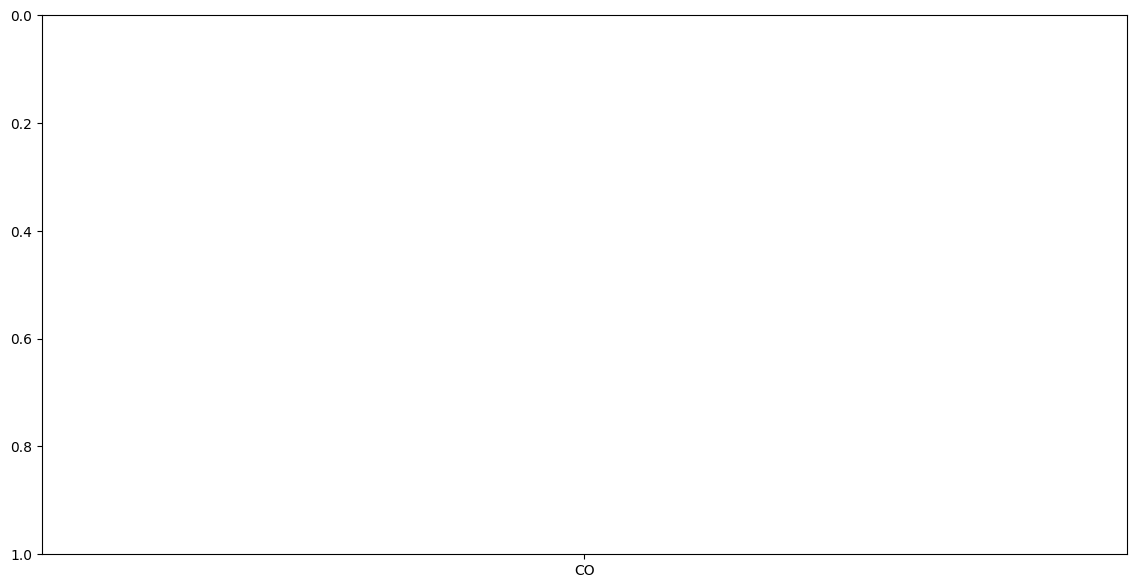

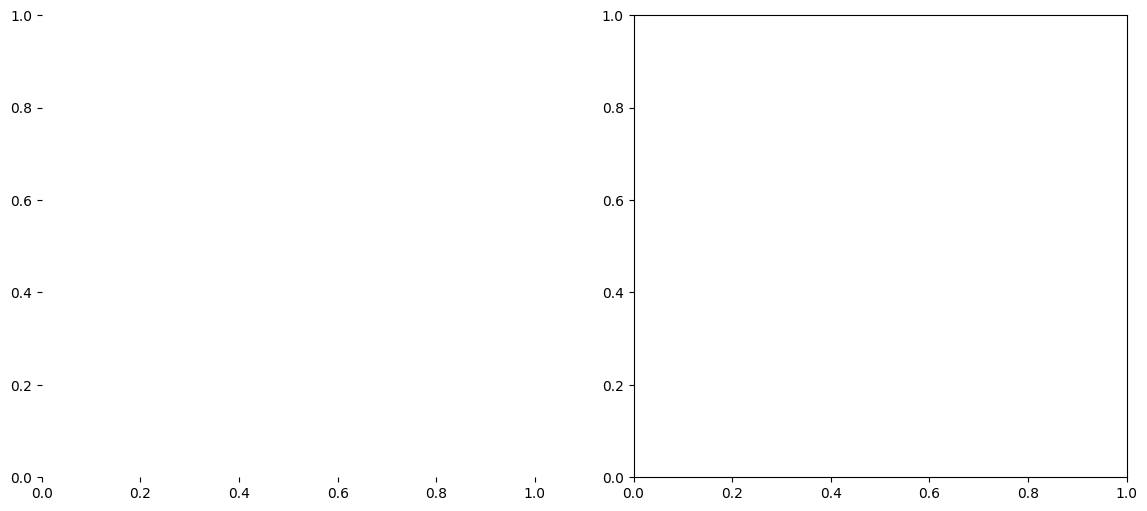

In [13]:
main()